In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# %reload_ext autoreload

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils

# Input Files

In [6]:
im1_name = DATA / (name + i + ".jpg")
im2_name = DATA / (name + j + ".jpg")
im1_name

PosixPath('data/plush/plush1.jpg')

In [8]:
name_a = im1_name.stem + "b" + im1_name.suffix
im1_name.parent / name_a

PosixPath('data/plush/plush1b.jpg')

In [90]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

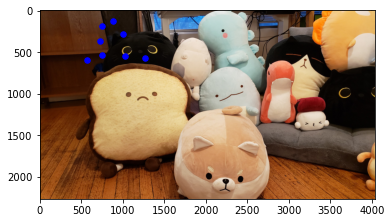

In [164]:
im1 = utils.read_img("data/plush1.jpg")
pts1 = utils.load_points("data/plush1.pkl")
utils.plot_pts(im1, pts1)

# Pick Correspondences

In [91]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [92]:
%matplotlib tk
im1_pts = utils.pick_points(im1, 4)
%matplotlib inline

Please select 4 points in image.
Picked 4 points successfully.


In [95]:
%matplotlib tk
im2_pts = utils.pick_points(im2, 4)
%matplotlib inline

Please select 4 points in image.
Picked 4 points successfully.


In [96]:
im1_pts

array([[1869.17741935, 1536.7       ],
       [2202.46774194,  244.18387097],
       [3007.24193548, 1284.7       ],
       [3194.20967742,  601.86129032]])

In [97]:
im2_pts

array([[1170.08064516, 1577.34516129],
       [1503.37096774,  268.57096774],
       [2283.75806452, 1284.7       ],
       [2446.33870968,  634.37741935]])

In [98]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print(f"input shape = {im1.shape}")
    print(f"target shape = ({h / r}, {w / r})")

RESIZE = True
ratio =  3
input shape = (2268, 4032, 3)
target shape = (756.0, 1344.0)


In [99]:
if RESIZE:
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts /= r
    im2_pts /= r

im1.shape

resizing...


(756, 1344, 3)

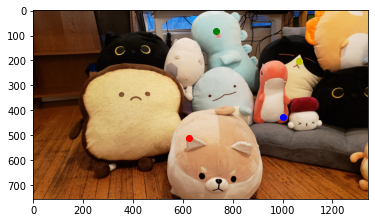

In [100]:
colors=["r", "g", "b", "y"]
fig = plt.figure()
plt.imshow(im1)
for i in range(len(im1_pts)):
    plt.scatter(im1_pts[i][0], im1_pts[i][1], color=colors[i])
plt.show()

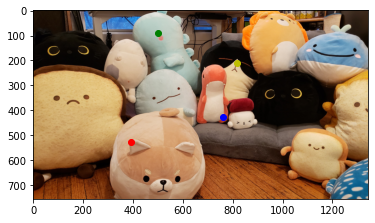

In [101]:
colors=["r", "g", "b", "y"]
fig = plt.figure()
plt.imshow(im2)
for i in range(len(im2_pts)):
    plt.scatter(im2_pts[i][0], im2_pts[i][1], color=colors[i])
plt.show()

# Image Rectification

In [56]:
# plane_pts = (im1_pts + im2_pts) / 2
# canvas = np.ones_like(im1)
# utils.plot_pts(canvas, plane_pts)

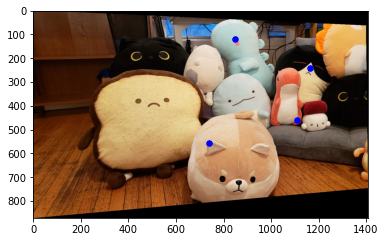

In [102]:
h_matrix1 = homography.homo_matrix(im1_pts, im2_pts)
warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
utils.plot_pts(warp1, warp_pts1)

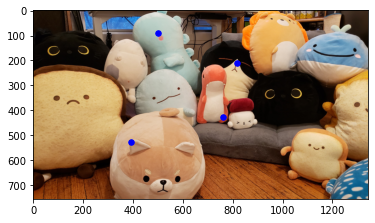

In [144]:
warp2 = im2
warp_pts2 = im2_pts

# h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
# warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
# warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

utils.plot_pts(warp2, warp_pts2)

In [145]:
# make copy of variables
warped_im1, warped_im2 = warp1, warp2
warped_im1_pts,warped_im2_pts = warp_pts1, warp_pts2

im1, im2, pts1, pts2 = warped_im1, warped_im2, warped_im1_pts,warped_im2_pts

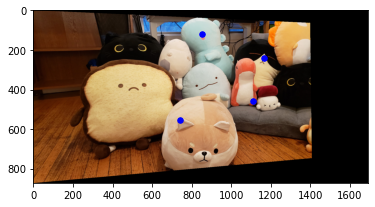

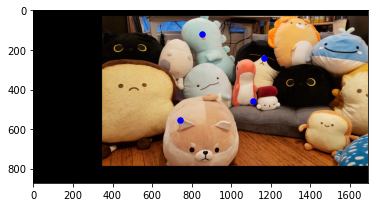

In [149]:
aligned1, aligned2, pts1, pts2 = rectification.align(warp1, im2, warp_pts1, im2_pts)
utils.plot_pts(aligned1, pts1)
utils.plot_pts(aligned2, pts2)

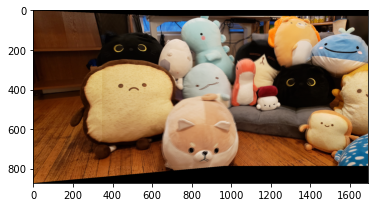

In [150]:
blended = rectification.average_blend(aligned1, aligned2)
plt.imshow(blended)

# blend 3rd image

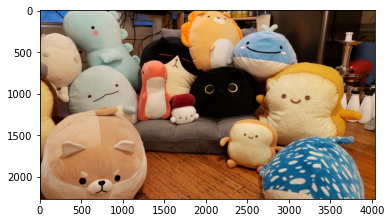

In [151]:
im3 = utils.read_img(DATA / (name + "3" + ".jpg"))
plt.imshow(im3)

In [152]:
%matplotlib tk
im3_pts = utils.pick_points(im3, 4)
%matplotlib inline

Please select 4 points in image.
Picked 4 points successfully.


In [153]:
im3_pts

array([[ 275.88709677, 1609.86129032],
       [ 633.56451613,  203.53870968],
       [1511.5       , 1252.18387097],
       [1641.56451613,  601.86129032]])

In [154]:
h, w, c = im3.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print(f"input shape = {im1.shape}")
    print(f"target shape = ({h / r}, {w / r})")

    print("resizing...")
    im3 = sk.transform.resize(im3, (im3.shape[0] // r, im3.shape[1] // r), anti_aliasing=True)
    im3_pts /= r

im3.shape

RESIZE = True
ratio =  3
input shape = (872, 1409, 3)
target shape = (756.0, 1344.0)
resizing...


(756, 1344, 3)

In [155]:
im3_pts

array([[ 91.96236559, 536.62043011],
       [211.18817204,  67.84623656],
       [503.83333333, 417.39462366],
       [547.18817204, 200.62043011]])

In [156]:
pts2

array([[ 739,  556],
       [ 850,  120],
       [1110,  458],
       [1164,  241]], dtype=int32)

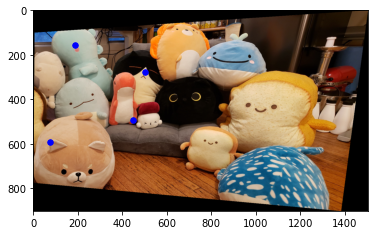

In [157]:
H = homography.homo_matrix(im3_pts, pts2)
warp3, shift_pts3 = homography.inverse_warp(im3, H)
warp_pts3 = homography.warp_pts(im3_pts, H, shift_pts3)
utils.plot_pts(warp3, warp_pts3)

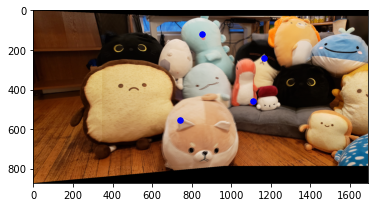

In [158]:
utils.plot_pts(blended, pts2)

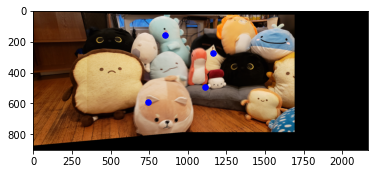

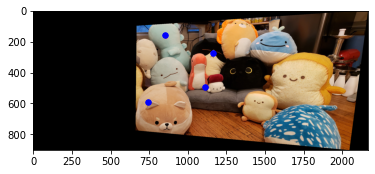

In [160]:
aligned12, aligned3, pts12, pts3 = rectification.align(blended, warp3, pts2, warp_pts3)
utils.plot_pts(aligned12, pts12)
utils.plot_pts(aligned3, pts3)

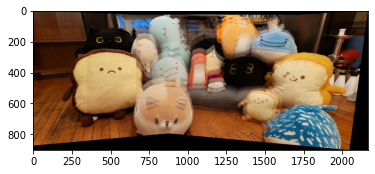

In [161]:
blended_plush = rectification.average_blend(aligned12, aligned3)
plt.imshow(blended_plush)

In [163]:
plt.imsave(OUTDIR/"part1/tmp.jpg", blended_plush)